In [2]:
from re import A
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
df = pd.read_excel('Patients Data ( Used for Heart Disease Prediction ).xlsx')

In [4]:
df.columns

Index(['PatientID', 'State', 'Sex', 'GeneralHealth', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'HadHeartAttack',
       'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory',
       'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver',
       'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [5]:
stcol = ['SmokerStatus','ECigaretteUsage','TetanusLast10Tdap']

In [6]:
for col in stcol:   
    print(df[col].unique())

['Former smoker' 'Never smoked' 'Current smoker - now smokes every day'
 'Current smoker - now smokes some days']
['Never used e-cigarettes in my entire life' 'Not at all (right now)'
 'Use them some days' 'Use them every day']
['No, did not receive any tetanus shot in the past 10 years'
 'Yes, received Tdap' 'Yes, received tetanus shot but not sure what type'
 'Yes, received tetanus shot, but not Tdap']


In [7]:
data_clean = df.drop(columns=["PatientID", 'HeightInMeters', "WeightInKilograms", "State"])

In [8]:
data_clean["AgeCategory"] = df["AgeCategory"].str.extract(r"(\d+)")
data_clean["AgeCategory"] = data_clean["AgeCategory"].astype(int)

data_clean = pd.get_dummies(data_clean, columns=['RaceEthnicityCategory'])

health_mapping = {
    "Excellent": 5,
    "Very good": 4,
    "Good": 3,
    "Fair": 2,
    "Poor": 1
}
data_clean["GeneralHealth"] = data_clean["GeneralHealth"].map(health_mapping)
data_clean["GeneralHealth"] = data_clean["GeneralHealth"].astype(int)

sex_mapping = {
    "Male": 1,
    "Female": 0
}

data_clean["Sex"] = data_clean["Sex"].map(sex_mapping)
data_clean["Sex"] = data_clean["Sex"].astype(int)

# MinMax scaling may not be suitable for Age and BMI in certain situations due to their inherent data properties. For Age, as it is showed in the form of intervals, MinMax scaling may not capture the ordinal nature or true differences between groups, and choosing the median of the interval might be more appropriate. For BMI, MinMax scaling is highly sensitive to outliers, which could skew the transformation and compress most values into a narrow range, leading to poor representation of meaningful differences in BMI categories.

def extract_mid_value(interval_str):
    """Extract the middle value from an interval or handle special cases like 'Age 80 or older'."""
    interval_str = interval_str.astype(str)
    
    match = interval_str.str.extract(r"(\d+)\s*to\s*(\d+)")
    mid_values = match.astype(float).mean(axis=1)

    # 'Age 80 or older'
    mid_values[interval_str.str.contains("80 or older", na=False)] = 80
    return mid_values

data_clean['AgeCategory'] = extract_mid_value(df['AgeCategory'])


# Encoding Smoker/Ecig status and TetanusLast10dap:

smoker_mapping = {
    'Never smoked': 0,
    'Former smoker': 1,
    'Current smoker - now smokes some days': 2,
    'Current smoker - now smokes every day': 3
}
data_clean['SmokerStatus'] = data_clean['SmokerStatus'].map(smoker_mapping)

ecig_mapping = {
    'Never used e-cigarettes in my entire life': 0,
    'Not at all (right now)': 1,
    'Use them some days': 2,
    'Use them every day': 3
}
data_clean['ECigaretteUsage'] = data_clean['ECigaretteUsage'].map(ecig_mapping)

tetanus_mapping = {
    'No, did not receive any tetanus shot in the past 10 years': 0,
    'Yes, received tetanus shot but not sure what type': 1,
    'Yes, received tetanus shot, but not Tdap': 2,
    'Yes, received Tdap': 3
}
data_clean['TetanusLast10Tdap'] = data_clean['TetanusLast10Tdap'].map(tetanus_mapping)
# Or use the ordinal one. I'm not familiar with the vaccine.

data_clean.head()

,Sex,GeneralHealth,AgeCategory,BMI,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos,"RaceEthnicityCategory_Black only, Non-Hispanic",RaceEthnicityCategory_Hispanic,"RaceEthnicityCategory_Multiracial, Non-Hispanic","RaceEthnicityCategory_Other race only, Non-Hispanic","RaceEthnicityCategory_White only, Non-Hispanic"
0,0,2,77.0,32.099998,0,1,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
1,0,4,67.0,27.990000,0,0,0,0,0,0,...,1,1,3,0,0,0,0,0,0,1
2,1,5,62.0,22.530001,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,4,72.0,30.129999,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
4,0,3,52.0,27.760000,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


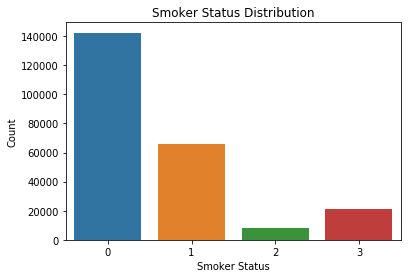

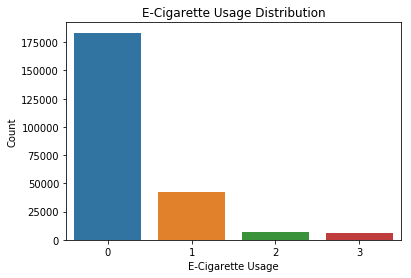

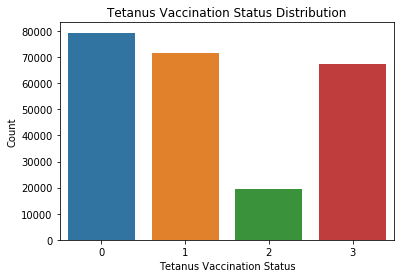

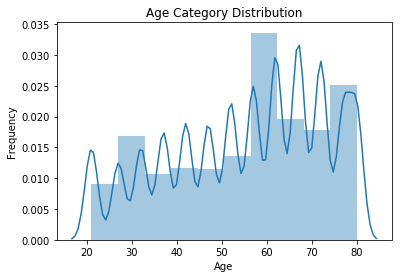

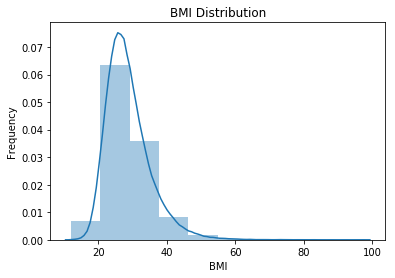

In [9]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SmokerStatus
sns.countplot(x=data_clean['SmokerStatus'])
plt.title('Smoker Status Distribution')
plt.xlabel('Smoker Status')
plt.ylabel('Count')
plt.show()

# ECigaretteUsage
sns.countplot(x=data_clean['ECigaretteUsage'])
plt.title('E-Cigarette Usage Distribution')
plt.xlabel('E-Cigarette Usage')
plt.ylabel('Count')
plt.show()

# TetanusLast10Tdap
sns.countplot(x=data_clean['TetanusLast10Tdap'])
plt.title('Tetanus Vaccination Status Distribution')
plt.xlabel('Tetanus Vaccination Status')
plt.ylabel('Count')
plt.show()

# AgeCategory

sns.distplot(data_clean['AgeCategory'], kde=True, bins=10)
plt.title('Age Category Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# BMI
sns.distplot(data_clean['BMI'], kde=True, bins=10)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

In [22]:
#running of cleaned HadDiabetes Column along with a model using only the test data
data_clean = data_clean[data_clean["HadDiabetes"] != "Yes, but only during pregnancy (female)"]
data_clean = data_clean[data_clean["HadDiabetes"] != "No, pre-diabetes or borderline diabetes"]


#Scaled the data to make it easier to compare the weights generated from our model for each feature afterwards.

from sklearn.preprocessing import StandardScaler
st_scaler = StandardScaler()
bmi = pd.DataFrame(data_clean, columns=['BMI'])
bmi = st_scaler.fit_transform(bmi)
data_clean['BMI'] = bmi
data_clean.head()

dSample = data_clean.sample(frac=0.01, random_state=42, axis=0)
dSample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2305 entries, 5854 to 29332
Data columns (total 35 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Sex                                                  2305 non-null   int32  
 1   GeneralHealth                                        2305 non-null   int32  
 2   AgeCategory                                          2305 non-null   float64
 3   BMI                                                  2305 non-null   float64
 4   HadHeartAttack                                       2305 non-null   int64  
 5   HadAngina                                            2305 non-null   int64  
 6   HadStroke                                            2305 non-null   int64  
 7   HadAsthma                                            2305 non-null   int64  
 8   HadSkinCancer                                        2305 non-nu

In [23]:
X = data_clean.drop("HadDiabetes", axis=1)
Y = data_clean['HadDiabetes']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

C:\Users\15358\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.98      0.92     39450
         Yes       0.55      0.18      0.27      6654

    accuracy                           0.86     46104
   macro avg       0.71      0.58      0.59     46104
weighted avg       0.83      0.86      0.83     46104



In [ ]:
# There are 39450 No and 6654 Yes. We can try SMOTE to synthesize the sample
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=500)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# But as the output shows, the number of Yes and No does not change as expected. There is a problem.


C:\Users\15358\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,



Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.77      0.84     39493
         Yes       0.31      0.61      0.41      6611

    accuracy                           0.75     46104
   macro avg       0.62      0.69      0.63     46104
weighted avg       0.83      0.75      0.78     46104



In [25]:
# Also in the report, the output says ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT. That is also a problem.
